# PCA Demo UCSL 2016
## By applying linear algebra decomposition of a set of portraits, we cn identify the characteristics in common to all portrates. Those are the Principal Components. Using a subset of these components we can reconstruct most of the images. This is why PCA is very used in image compression: we can reduce the amount of data we store, and still preserve most of the "information content"

Original reference:Turk and Pentland 1991 http://www.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf

Here is a tutorial with the math, if you are interested. https://www.clear.rice.edu/elec301/Projects99/faces/images.html

In [2]:
from __future__ import print_function
__author__ = 'fbb'


import numpy as np
import pylab as pl
%pylab inline

from PIL import Image
from scipy.misc import imread
import json
import os

import glob

s = json.load( open(os.getenv ('PUI2016') + "/fbb_matplotlibrc.json") )
pl.rcParams.update(s)



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# DECOMPOSING FACES INTO THEIR PRINCIPAL COMPONENTS



## Reading in the images

There are N = 81 images
The size of each image is: H, W (80, 50)


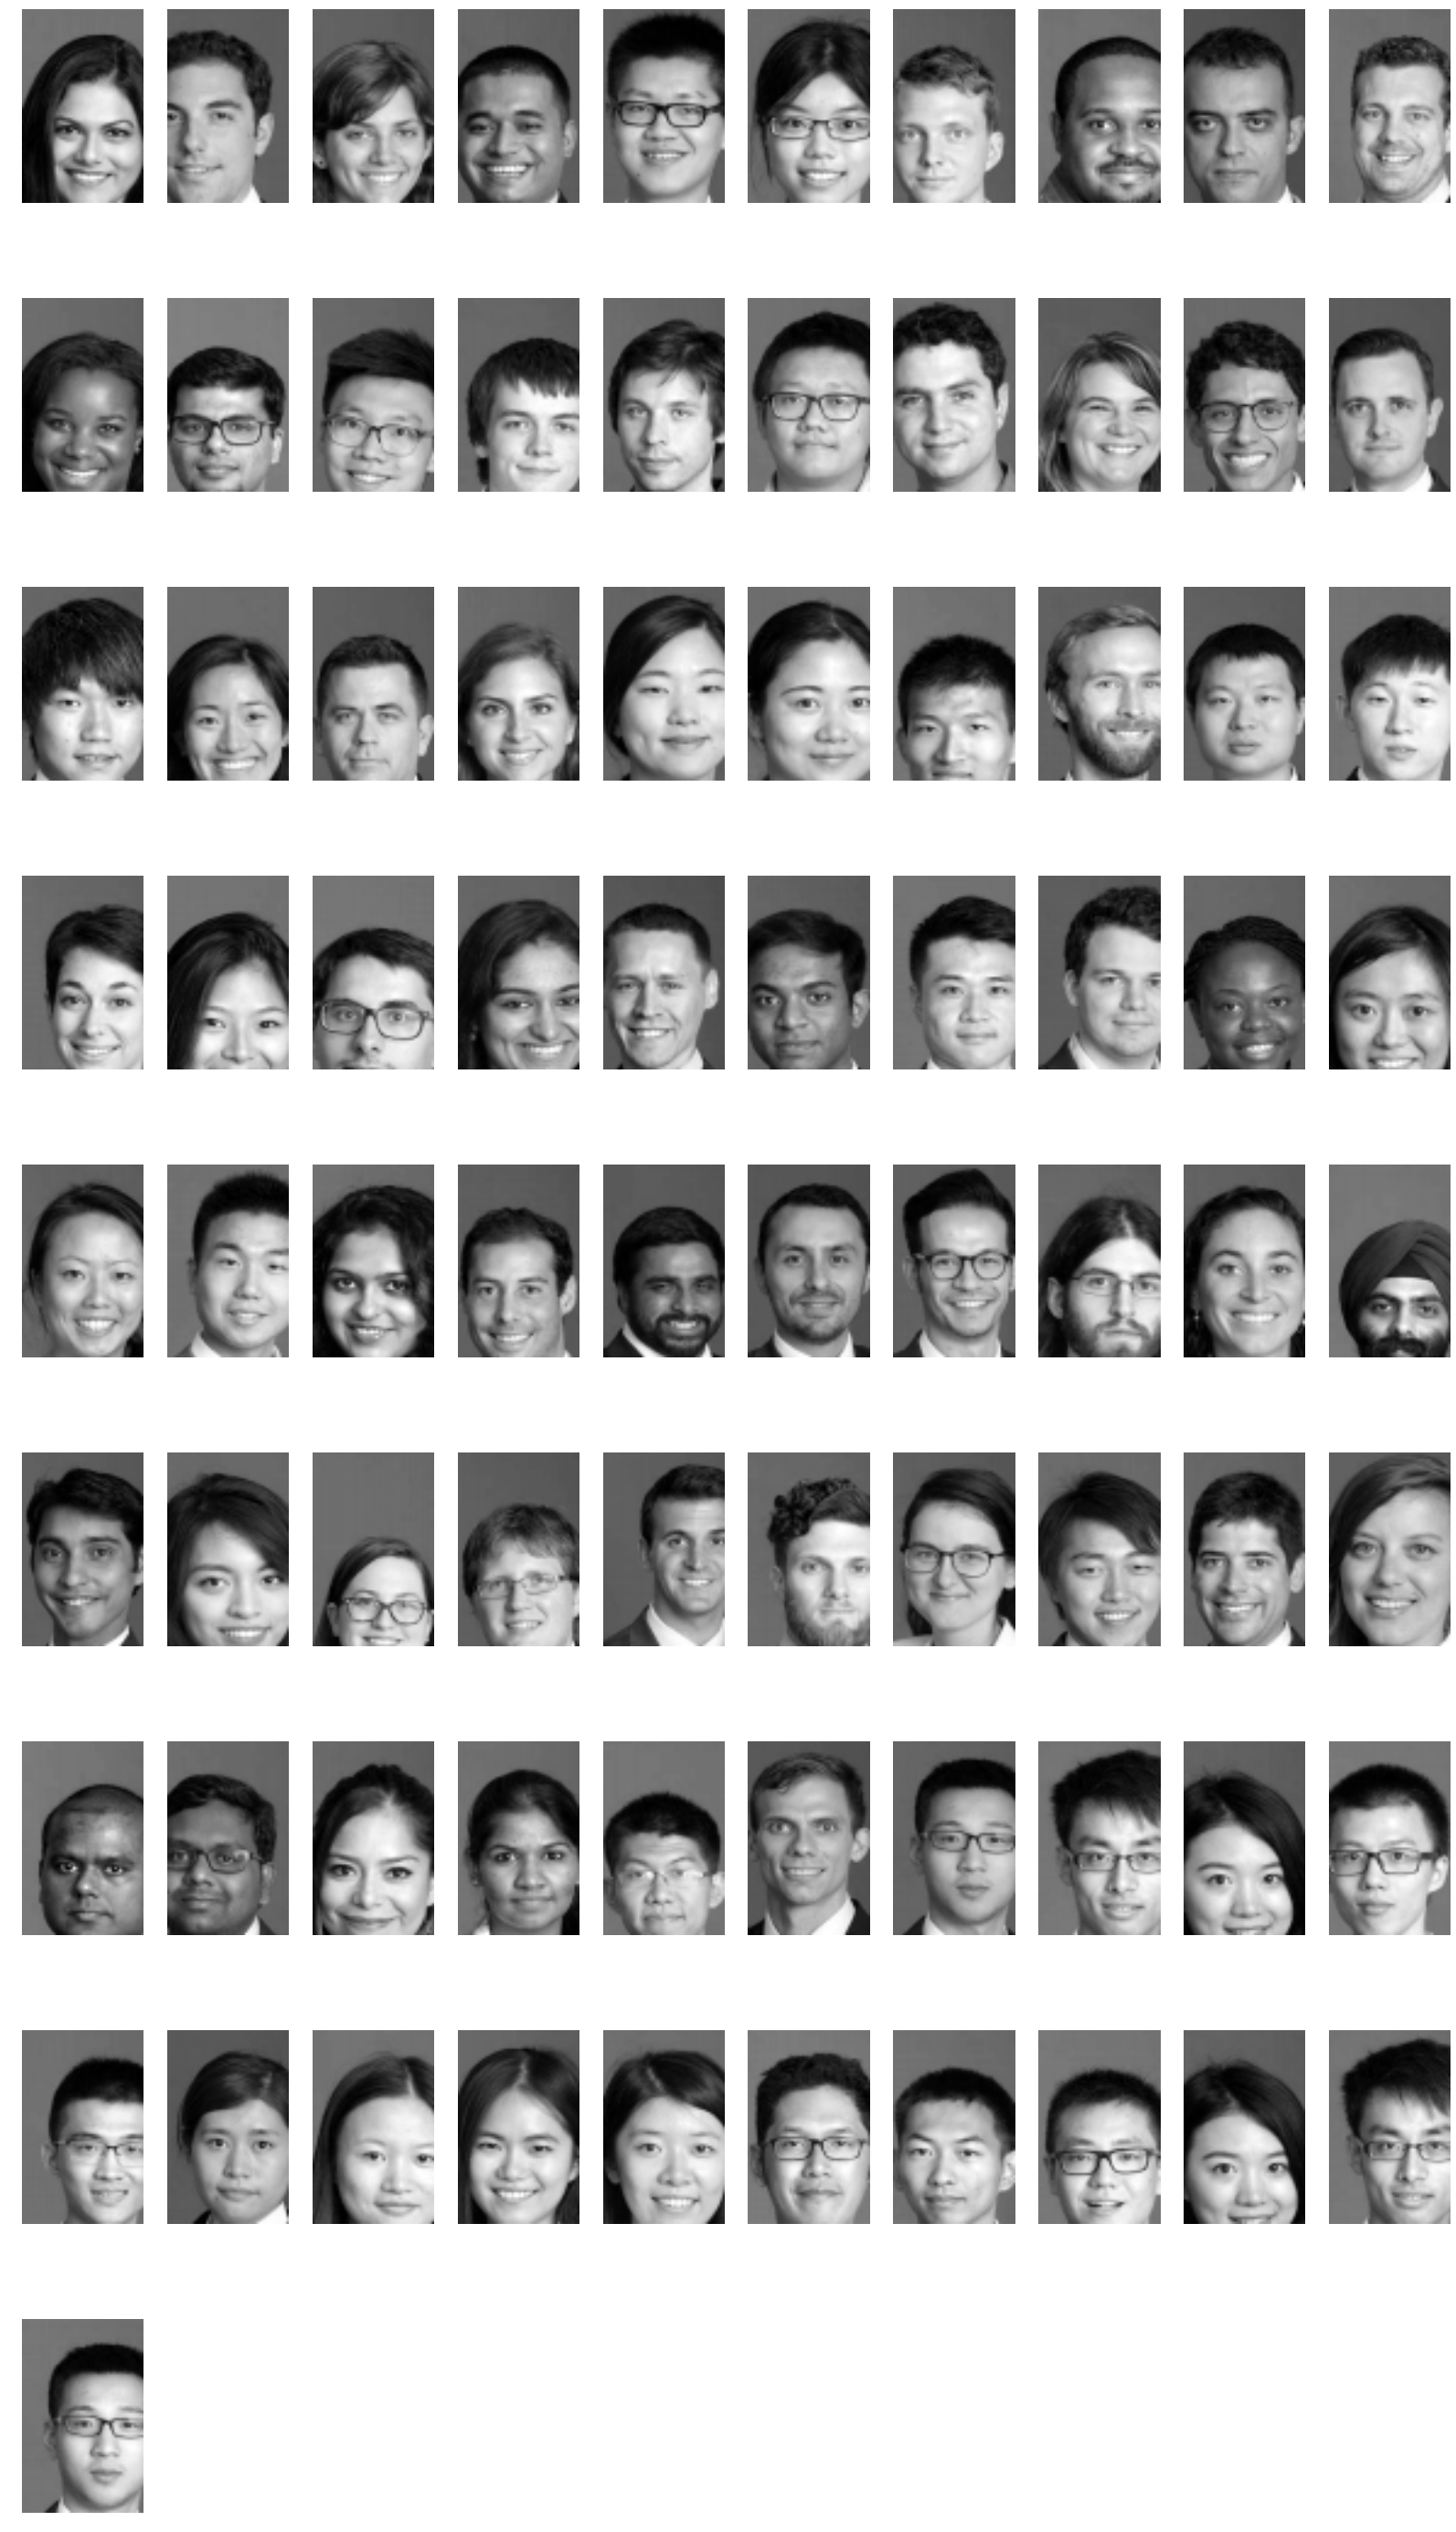

In [4]:
# the images are portraits of CUSP students. And they are more than just faces: they are taken from the midsectio up.
# Cropping them will extract roughly the face
H=80
W=50 
listf = np.array(glob.glob("faces/*"))
# I will host the cropped images in an array, of size NumberOfImages,ImageHeight,ImageWidth
# here I create an empty array to host them.
allimgs = np.zeros((len(listf),H,W))
imn =  len(listf)

# reading the images and moving the cropped versio (the relevant data) into the empty array 
# by "slicing" each image, after reading it in as an array
# the [20:100,45:95,:3] is the slice, 
# images generally are 3dimensional arrays: heights, width, and color, which in most cases is 
# conveyed by 3 colors, R, G, b, and thus each pixel is expressed by an array of 3 numbers, 
# and occasionally also contains the opacity of that pixel: a 4 values array. 
# and I average the value along the last colmun with .mean(axis=2)
# thus taking the average of the R G and B iage channels
for i,f in enumerate(listf):
    im = imread(f)
    allimgs[i] = im[20:100, 45:95, :3].mean(axis=2)
k = 1
fig = pl.figure(figsize = (28,50))   
for im in allimgs:
    ax = fig.add_subplot(9, 10, k)
    ax.axis('off')
    ax.imshow(im, cmap = "gist_gray")
    k = k + 1
print ("There are N = %d images"%allimgs.shape[0])
print ("The size of each image is: H, W", allimgs.shape[1:])

## normalizing the images

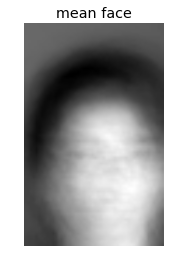

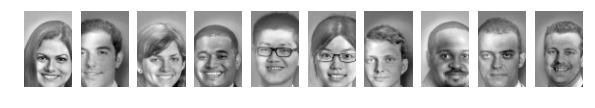

In [5]:
# I will take the mean  (pixel by pixel) of all the images, and subtract it from each image. 
# This is a "data normalization"
# mean(axis=0) takes the mean pixel by pixel of all images
mean_image = allimgs.mean(axis=0)

pl.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
pl.axis('off')
pl.title("mean face")

# normalizing all the faces: we remove the mean of all images from each image, pixel by pixel
arr_norm = np.zeros([imn, H*W])
arr_norm = allimgs - mean_image
k=1
fig = pl.figure(figsize=(10,10))
for im in arr_norm[:10]:
    ax = fig.add_subplot(1,10,k)
    ax.axis('off')
    ax.imshow(im, cmap="gist_gray")
    k=k+1


In [6]:
# Really I want the n by m image arrays to be represented as nxm vectors: 
# the spacial arrangements of the pixels is irrelevant to the computer for this pur?"
print ("shape of each image: N,H,W:", arr_norm.shape)
flatfaces = np.zeros((arr_norm.shape[0], 
                      arr_norm.shape[1]*arr_norm.shape[2]))
for i,face in enumerate(arr_norm):
    flatfaces[i] = face.flatten()    
print ("shape of each flattened image array: N,HxW:", flatfaces.shape)


shape of each image: N,H,W: (81, 80, 50)
shape of each flattened image array: N,HxW: (81, 4000)


## PCA

In [7]:
# here comes the Princeiple Component Analysis
from sklearn.decomposition.pca import PCA
pca = PCA()
pca.fit(flatfaces)

# this is the cumulative explained variance: 
# how much of the dataset can be described as a linear combination of the eigenfaces 
# up to the current one
explVar = pca.explained_variance_ratio_
# i want the cumulative sum 
explVar = explVar.cumsum()
# eigenfaces
eigenfaces = pca.components_

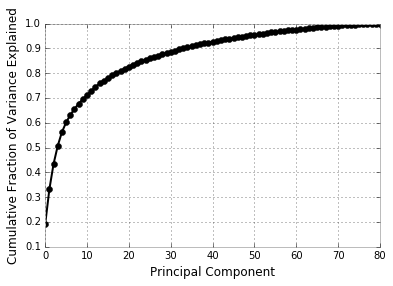

In [8]:
# This is a plot showing hoe important each component is in reconstructing the signal
# The first componentcontains ~20% (~0.19) of the information in the sample, the second component
# contains ~14% (0.33 - 0.19) etc. 
    
plt.plot(explVar, 'k-o')
plt.ylabel("Cumulative Fraction of Variance Explained")
plt.xlabel("Principal Component")

## plot the eigenfaces


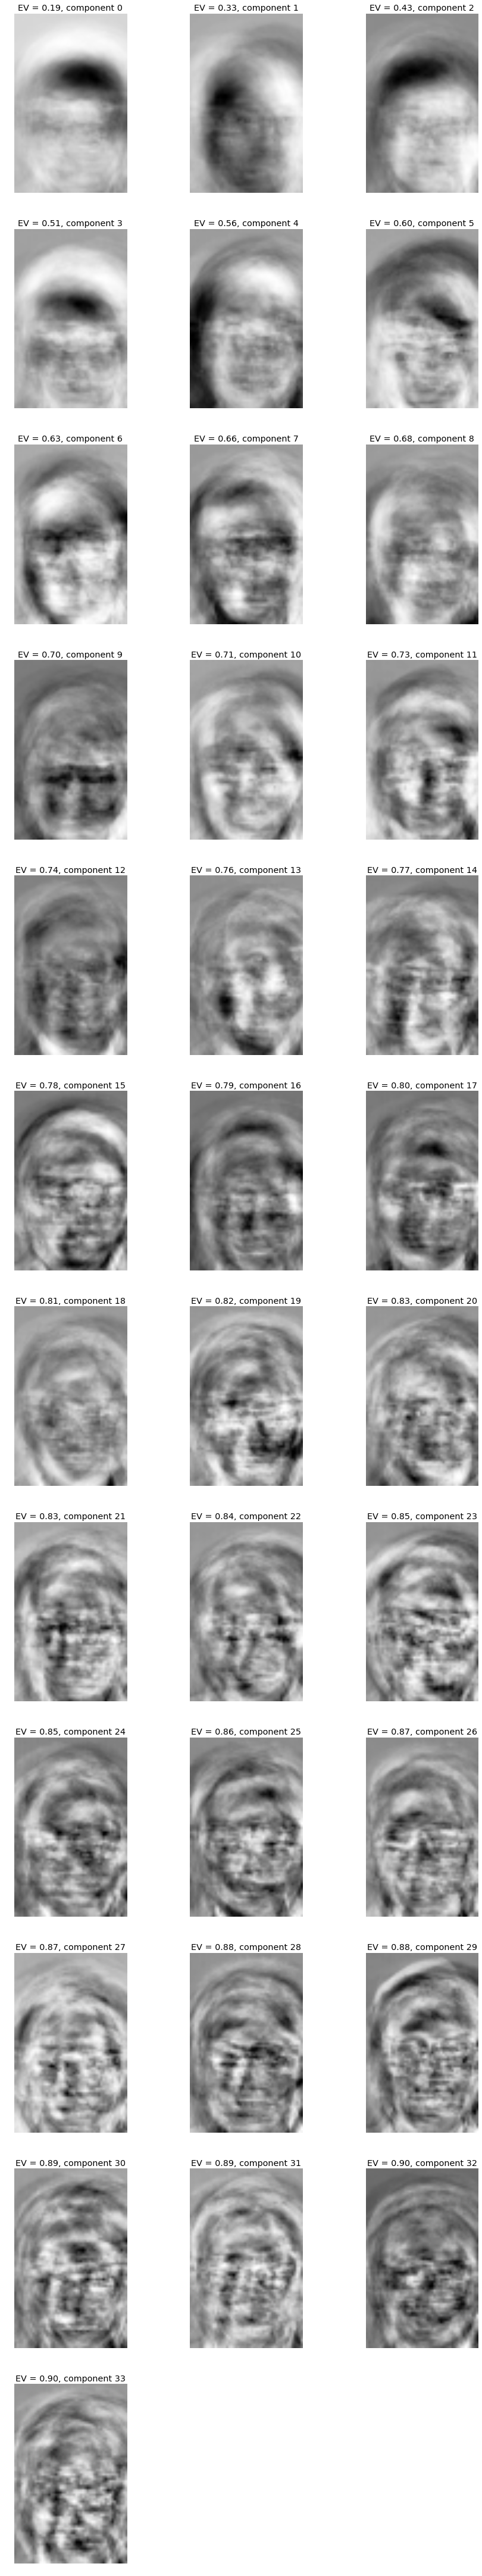

In [9]:

fig = pl.figure(figsize=(15,265))
for i,im in enumerate(eigenfaces):
    ax = fig.add_subplot(41,3,i+1)
    ax.axis('off')
    ax.imshow(im.reshape([H,W]), cmap = plt.get_cmap("Greys"))
    ax.set_title("EV = {:.2f}, component {:d}".format(explVar[i], i))
    if explVar[i]>0.9: 
        break
    
 

## Reconstruct images in the set

//anaconda/envs/p2nb/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


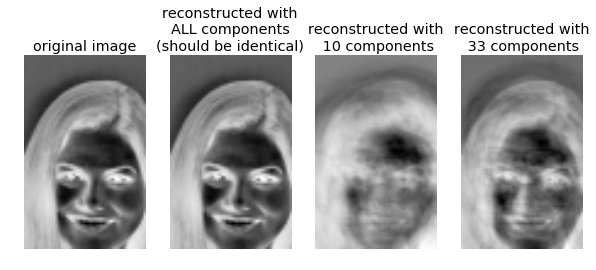

In [10]:
## We can use the principal components to reconstructi any image in the set.
## The more PCs we use, the more faithful the riconstruction is 

# reconstruct a face from the eigenvectors
faceid = 0
fig = pl.figure(figsize = (10,10))
ax = fig.add_subplot(141)
ax.imshow(arr_norm[faceid], cmap = plt.get_cmap("Greys"))
ax.axis('off')
ax.set_title('original image')

# reconstruct the face with all the components
egvalues = pca.transform(flatfaces[faceid])
reconstructedFace = np.dot(egvalues, pca.components_)
ax = fig.add_subplot(142)
ax.imshow(reconstructedFace.squeeze().reshape(H, W), 
          cmap = plt.get_cmap("Greys"))
ax.axis('off')
ax.set_title('reconstructed with\nALL components\n(should be identical)')

# only use 10 PCs
reconstructedFace = np.dot(egvalues[:,:10], pca.components_[:10])
ax = fig.add_subplot(143)
ax.imshow(reconstructedFace.squeeze().reshape(H, W), 
          cmap = plt.get_cmap("Greys"))
ax.axis('off')
ax.set_title('reconstructed with\n 10 components')

# only use PCs up to 80% explained variance
reconstructedFace = np.dot(egvalues[:,:33], pca.components_[:33])
ax = fig.add_subplot(144)
ax.imshow(reconstructedFace.squeeze().reshape(H, W), 
          cmap = plt.get_cmap("Greys"))
ax.axis('off')
ax.set_title('reconstructed with\n 33 components')


## here is the same process done with better data: 
## the faces are properly cropped so that they are centeres.
### the hair is removed, because it tends to be a very important feature, 
### that however does not define "a face"

### these data were collected by the Rice Eigenfaces group: https://www.clear.rice.edu/

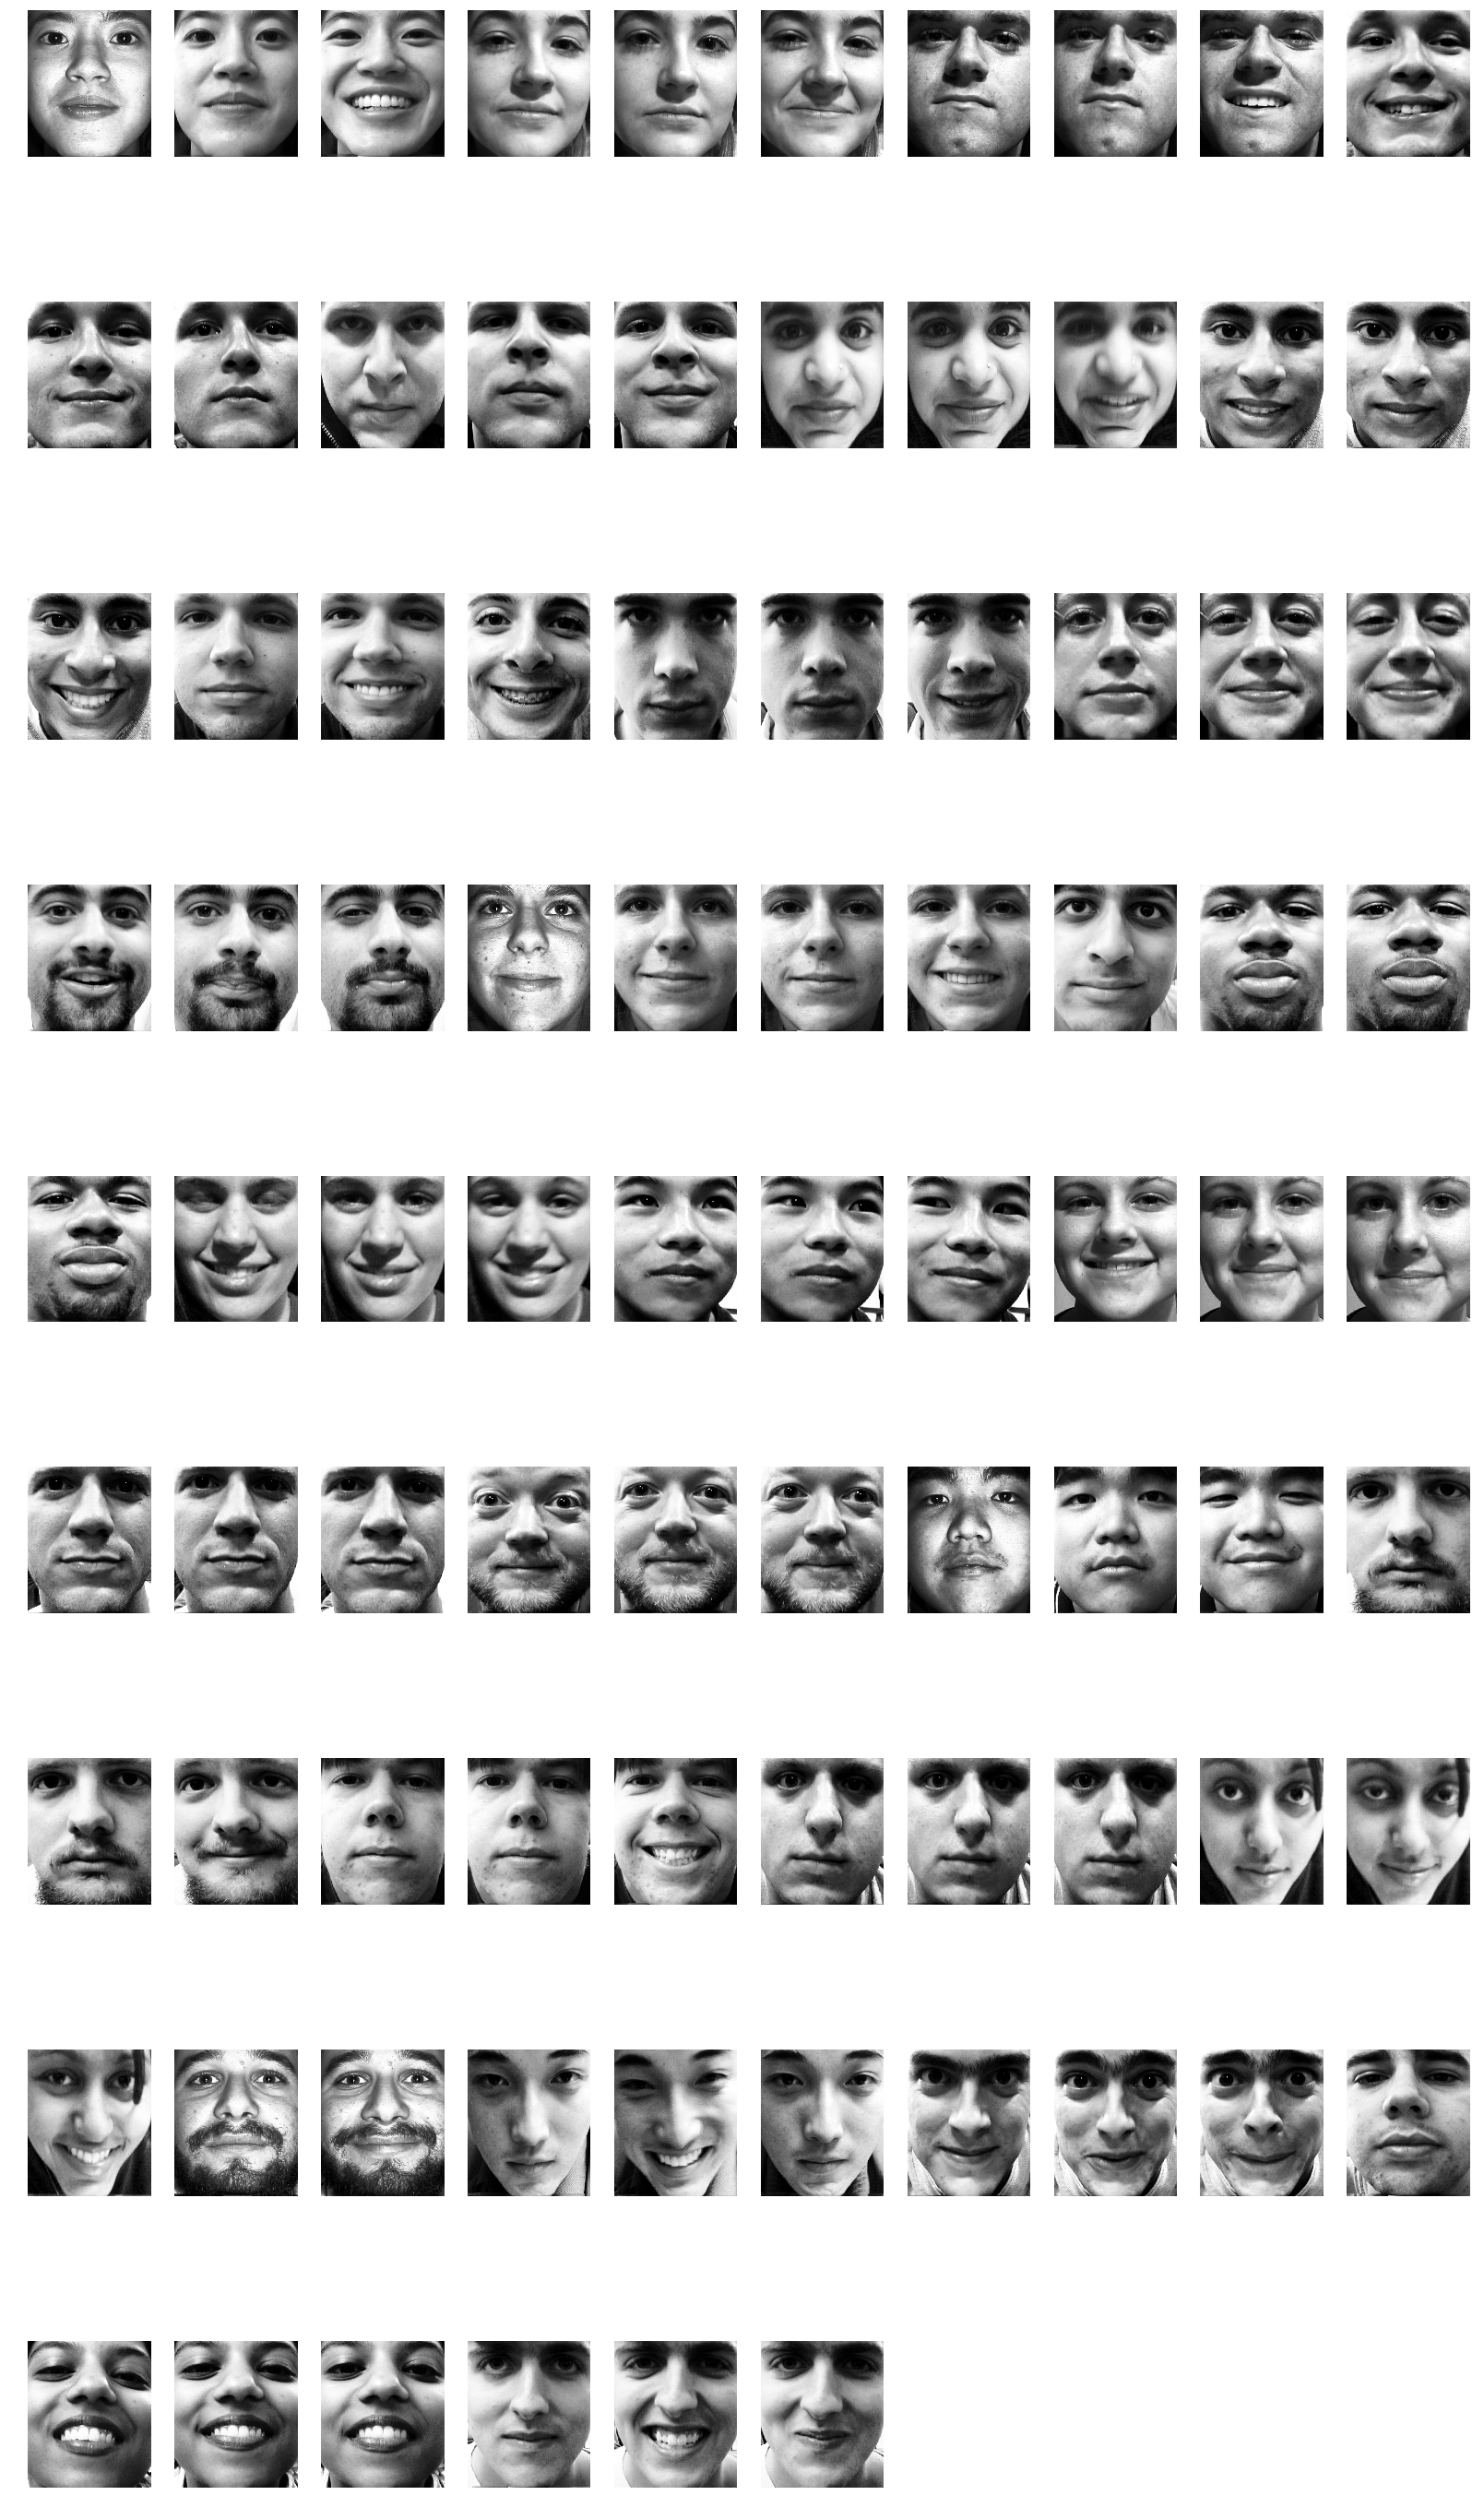

In [11]:
H, W = 300, 250
listf = np.array(glob.glob("FacesForEigenfaces/*gif"))
allimgs2 = np.zeros((len(listf),H,W))
imn =  len(listf)

# reading the images, this time using the PIL library
k = 1
fig = pl.figure(figsize = (28,50))   
for i,f in enumerate(listf):
    ax = fig.add_subplot(9, 10, k)
    ax.axis('off')    
    allimgs2[i] = Image.open(f).convert('L')
    ax.imshow(allimgs2[i], cmap="gist_gray")
    k += 1

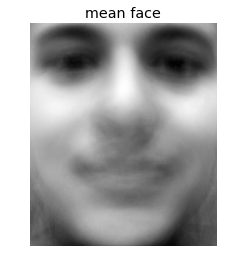

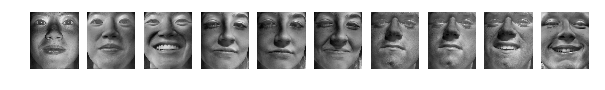

In [12]:
mean_image2 = allimgs2.mean(axis=0)

pl.imshow(np.reshape(mean_image2,[H,W]), cmap = plt.get_cmap("gray"))
pl.axis('off')
pl.title("mean face")

# normalizing all the faces: we remove the mean of all images from each image, pixel by pixel
arr_norm2 = np.zeros([imn, H*W])
arr_norm2 = allimgs2 - mean_image2
k=1
fig = pl.figure(figsize=(10,10))
for im in arr_norm2[:10]:
    ax = fig.add_subplot(1,10,k)
    ax.axis('off')
    ax.imshow(im, cmap="gist_gray")
    k=k+1


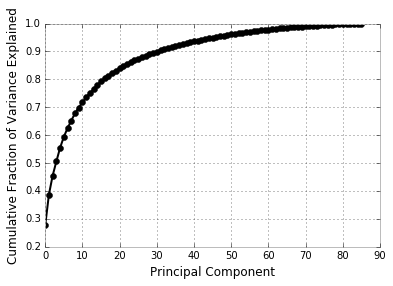

In [13]:
flatfaces = np.zeros((arr_norm2.shape[0], 
                      arr_norm2.shape[1]*arr_norm2.shape[2]))
for i,face in enumerate(arr_norm2):
    flatfaces[i] = face.flatten()    
from sklearn.decomposition.pca import PCA
pca = PCA()
pca.fit(flatfaces)

# this is the cumulative explained variance: 
# how much of the dataset can be described as a linear combination of the eigenfaces 
# up to the current one
explVar = pca.explained_variance_ratio_
# i want the cumulative sum 
explVar = explVar.cumsum()
# eigenfaces
eigenfaces = pca.components_
plt.plot(explVar, 'k-o')
plt.ylabel("Cumulative Fraction of Variance Explained")
plt.xlabel("Principal Component")

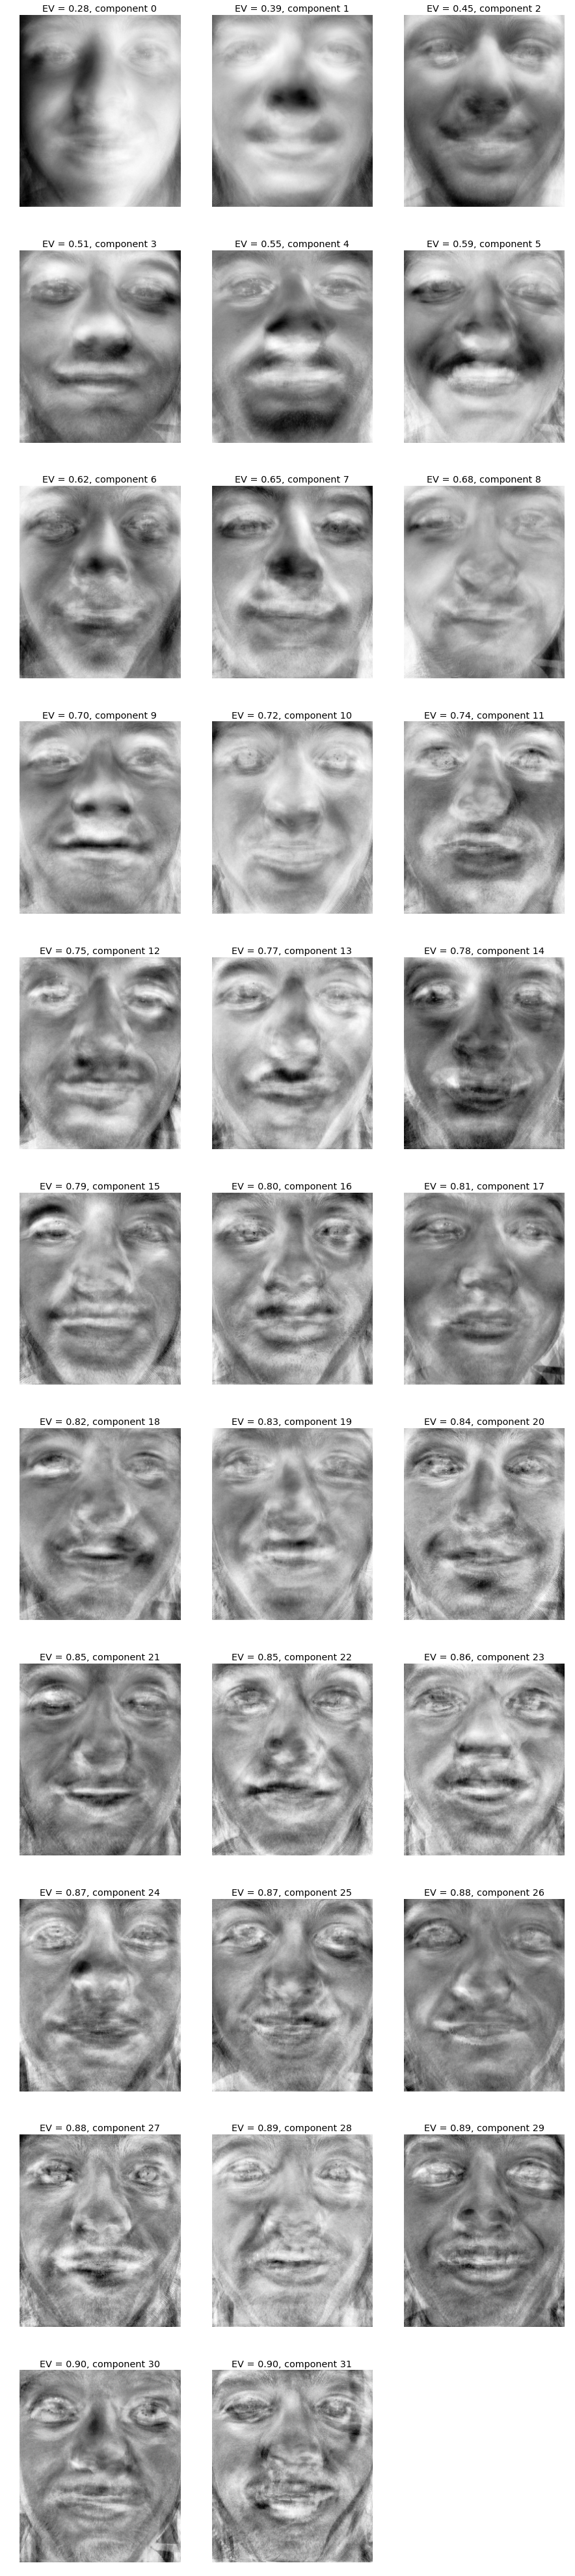

In [14]:
fig = pl.figure(figsize=(15,265))
for i,im in enumerate(eigenfaces):
    ax = fig.add_subplot(41,3,i+1)
    ax.axis('off')
    ax.imshow(im.reshape([H,W]), cmap = plt.get_cmap("Greys"))
    ax.set_title("EV = {:.2f}, component {:d}".format(explVar[i], i))
    if explVar[i]>0.9: 
        break
